<h2 align=center>Time Series Forecasting and Anomaly Detection with Keras</h2>


#  Loading Data and Visualizations

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
# rcParams['figure.figsize'] = 20, 10
np.random.seed(1)
tf.random.set_seed(1)

# print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
# !ls "/content/drive/My Drive"

data = pd.read_csv('/content/drive/My Drive/S&P_500_Index_Data.csv', parse_dates=['date'])
data.shape

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


(8192, 2)

In [ ]:
data.head()

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97


In [ ]:
# interactive line plot
fig = px.line(data, x='date', y='close', title='Stock Closing Prices')
fig.show()

# interactive histogram
fig = px.histogram(data, x='close', histnorm='probability density')
fig.show()

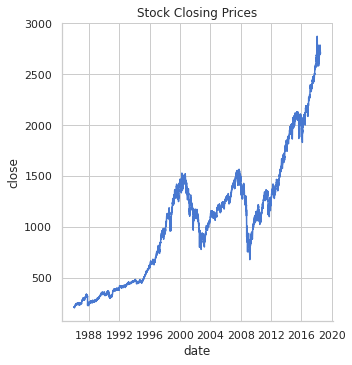

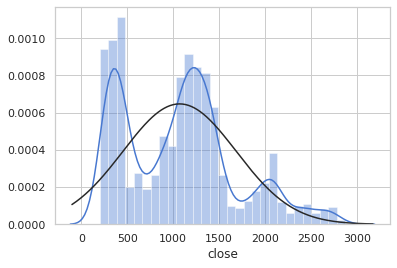

In [ ]:
# non-interactive line plot and histogram
sns.relplot(x='date', y='close', data=data, kind='line')
plt.title('Stock Closing Prices')
plt.show()

from scipy.stats import norm
sns.distplot(data['close'], fit=norm)
plt.show()

# Time Series Forecasting

## Baseline Predictions



Take a detour and talk about baseline prediction algorithms. 

Establishing a baseline model is essential in any time series forecasting problem (any prediction problem in general): It will give us an idea of how well all other models perform. A baseline prediction algorithm provides a set of predictions that you can evaluate as you would any predictions for your problem, such as classification accuracy or RMSE. The scores from these algorithms provide the required point of comparison when evaluating all other machine learning algorithms on your problem.

The two most commonly used for classification and regression:
* **Random Prediction Algorithm**
    - Predicts based on random choice of train dataset row index
* **Zero Rule Algorithm**
    - For classification, predicts the majority class
    - For regression, predicts the mean (you could extend to median, mode, or moving average for time series problems where the mean of the last n records is predicted, etc.)

A common algorithm used in establishing a baseline performance for time series modeling is the **persistence algorithm** (the "naive" forecast). It uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

For our univariate time series problem, let us develop a persistence model and use it to establish a baseline performance.

Let us first separate the dataset into train and test sets.

In [ ]:
train_size = int(len(data)*0.8)

train, test = data.iloc[:train_size].reset_index(drop=True), data.iloc[train_size:].reset_index(drop=True)
print(f'Train Shape: {train.shape}\nTest Shape: {test.shape}')

Train Shape: (6553, 2)
Test Shape: (1639, 2)


In [ ]:
y_pred = test['close'].drop(len(test)-1)
y_test = test['close'].shift(-1).drop(len(test)-1)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: ${round(np.sqrt(mse),4)}')

RMSE: $15.6731


The Root Mean Squared Error is 15.6708.

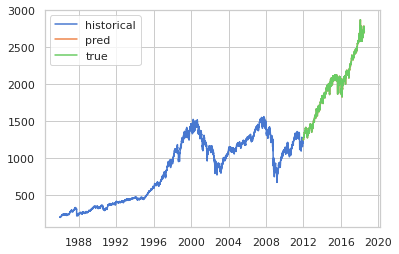

In [ ]:
# plot predictions and expected results
plt.plot(train['date'], train['close'], label='historical')
plt.plot(test['date'][1:], y_pred, label='pred')
plt.plot(test['date'][1:], y_test, label='true')
plt.legend()
plt.show()


Now that we have a baseline of performance on the dataset, we can get started developing an LSTM model for the data.


However, based on the difference in prices, the range of prices, and the relatively decent RMSE we get from using a baseline model, we can infer that an LSTM model will be marginally useful. A statistical approach will be better. But for the fun of it, let us go ahead.


## Transform Time Series to Stationary

Stationary data, not dependent on time, is easier to model. The trend can be removed and then added back later to return predictions to original scale and get comparable metric.

We can remove the trend by differencing the data, so we are left with a difference series, i.e., the changes from one time step to another.

In [ ]:
# create a differenced column in dataframe
def difference(dataset):
  size = len(dataset)
  dataset['t+1'] = dataset['close'].shift(-1) - dataset['close']
  dataset['t'] = dataset['t+1'].shift(1).fillna(0)
  return dataset.drop(size-1)
 
# invert differenced column in dataframe
def inverse_difference(y_pred, dataset):
  close_pred = dataset['close'] + y_pred
  return close_pred

In [ ]:
data = difference(data)

In [ ]:
data

,date,close,t+1,t
0,1986-01-02,209.59,1.29,0.00
1,1986-01-03,210.88,-0.23,1.29
2,1986-01-06,210.65,3.15,-0.23
3,1986-01-07,213.80,-5.83,3.15
4,1986-01-08,207.97,-1.86,-5.83
...,...,...,...,...
8186,2018-06-22,2754.88,-37.81,5.12
8187,2018-06-25,2717.07,5.99,-37.81
8188,2018-06-26,2723.06,-23.43,5.99
8189,2018-06-27,2699.63,16.68,-23.43


## Transform Time Series to Supervised Learning

In Keras, to work with LSTM we need input X and output y. For a time series problem we can let the input X be the observation from time t and the output y be the observation from time (t+1). This will give us data ready for supervised learning. Hence, the earlier step of adding the 't' and 't+1' columns.


### Transform Time Series to Scale

In [ ]:
# before transforming to scale we need to split into train, val, test sets.

train, val, test = data.iloc[:int(train_size*0.80)].reset_index(drop=True), data.iloc[int(train_size*0.80):train_size].reset_index(drop=True), data.iloc[train_size:].reset_index(drop=True)
print(f'Train Shape: {train.shape}\nVal Shape: {val.shape}\nTest Shape: {test.shape}')

Train Shape: (5242, 4)
Val Shape: (1311, 4)
Test Shape: (1638, 4)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = MinMaxScaler(feature_range=(-1, 1)).fit(train[['t']])
scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(train[['t+1']])

train['t'] = scaler_x.transform(train[['t']])
train['t+1'] = scaler_y.transform(train[['t+1']])

val['t'] = scaler_x.transform(val[['t']])
val['t+1'] = scaler_y.transform(val[['t+1']])

test['t'] = scaler_x.transform(test[['t']])
test['t+1'] = scaler_y.transform(test[['t+1']])


In [ ]:
train

,date,close,t+1,t
0,1986-01-02,209.59,0.134416,0.117248
1,1986-01-03,210.88,0.114187,0.134416
2,1986-01-06,210.65,0.159170,0.114187
3,1986-01-07,213.80,0.039659,0.159170
4,1986-01-08,207.97,0.092494,0.039659
...,...,...,...,...
5237,2006-10-04,1350.22,0.157173,0.331648
5238,2006-10-05,1353.22,0.068805,0.157173
5239,2006-10-06,1349.58,0.131621,0.068805
5240,2006-10-09,1350.66,0.153979,0.131621


In [ ]:
train_array = train.to_numpy()
val_array = val.to_numpy()
test_array = test.to_numpy()

### LSTM Model Development

The LSTM layer in Keras expects input to have dimensions **[samples, time steps, features].** 

FYI time steps = sequence length. 



In [ ]:
time_steps = 1
X_train, y_train = train_array[:, -1].reshape(-1,1), train_array[:, -2].reshape(-1,1)
X_val, y_val = val_array[:, -1].reshape(-1,1), val_array[:, -2].reshape(-1,1)  
X_test, y_test = test_array[:, -1].reshape(-1,1), test_array[:, -2].reshape(-1,1)

In [ ]:
X_train.shape

(5242, 1)

In [16]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs, dtype=np.float), np.array(ys, dtype=np.float)

In [ ]:
X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_val, y_val = create_dataset(X_val, y_val, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(5241, 1, 1) (1310, 1, 1) (1637, 1, 1)


In [ ]:
!pip install livelossplot

As an aside: An LSTM predicts based on the activation of the memory cell in the previous timestep. This is important to keep in mind when thinking of whether to use stateful or stateless in RNNs. Do you want to copy the activation between batches? Or do you set it to all zeroes? That is what distinguishes a stateful and stateless RNN. State refers to neuron activations, not to the parameters (which are kept in either case).

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from livelossplot.inputs.tf_keras import PlotLossesCallback

epochs = 5
batch_size = 1

def build_model(neurons=4,
                batch_size=batch_size,
                stateful=True):
  
  layer = LSTM(neurons, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=stateful)

  model = Sequential()
  model.add(layer)
  model.add(Dense(1))
  
  opt = Adam(learning_rate=0.0005)
  model.compile(loss='mean_squared_error',
                optimizer=opt, metrics=['mean_squared_error'])
  print(model.summary())

  return model

In [ ]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    96        
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=5, verbose=0, mode='min', restore_best_weights=False)
# csv_logger = CSVLogger('/content/drive/My Drive/training.log')
# callbacks = [PlotLossesCallback(), early_stopping, csv_logger]
# callbacks = [early_stopping]
# callbacks = [PlotLossesCallback(),  csv_logger]

history = []
for i in range(epochs):
  training = model.fit(X_train, 
            y_train, 
            epochs=1, 
            batch_size=batch_size, 
            verbose=2, 
            #validation_split=0.2,
            shuffle=False, # no shuffling, as it will permute the training data and get batches of size batch_size, with time series we want to preserve order
            validation_data=(X_val, y_val)
            )
  history.append(training.history)
  if i != (epochs-1):
    model.reset_states()

5241/5241 - 19s - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
5241/5241 - 18s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
5241/5241 - 18s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
5241/5241 - 18s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0562 - val_mean_squared_error: 0.0562
5241/5241 - 18s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0563 - val_mean_squared_error: 0.0563


In [ ]:
history

[{'loss': [0.015389123000204563],
  'mean_squared_error': [0.015389123000204563],
  'val_loss': [0.056303225457668304],
  'val_mean_squared_error': [0.056303225457668304]},
 {'loss': [0.015232671052217484],
  'mean_squared_error': [0.015232671052217484],
  'val_loss': [0.05623853951692581],
  'val_mean_squared_error': [0.05623853951692581]},
 {'loss': [0.015202166512608528],
  'mean_squared_error': [0.015202166512608528],
  'val_loss': [0.056233372539281845],
  'val_mean_squared_error': [0.056233372539281845]},
 {'loss': [0.015188307501375675],
  'mean_squared_error': [0.015188307501375675],
  'val_loss': [0.056240834295749664],
  'val_mean_squared_error': [0.056240834295749664]},
 {'loss': [0.015183061361312866],
  'mean_squared_error': [0.015183061361312866],
  'val_loss': [0.05625009164214134],
  'val_mean_squared_error': [0.05625009164214134]}]

In [ ]:
train_loss = []
train_mse = []
val_loss = []
val_mse = []

for i in range(len(history)):
  train_loss.append(history[i]['loss'][0])
  train_mse.append(history[i]['mean_squared_error'][0])
  val_loss.append(history[i]['val_loss'][0])
  val_mse.append(history[i]['val_mean_squared_error'][0])
  

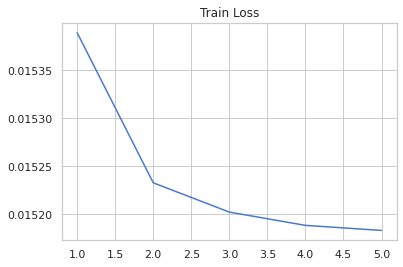

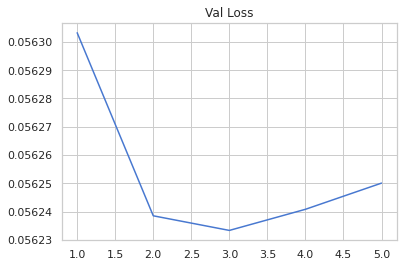

In [ ]:
plt.plot([1,2,3,4,5], train_loss)
plt.title('Train Loss')
plt.show()
plt.title('Val Loss')
plt.plot([1,2,3,4,5], val_loss)
plt.show()

### LSTM Forecast

Three possible approaches: We could,
1. Forecast the entire training dataset to build up state for forecasting
2. Directly start forecasting, which would imply we would have no state since we reset_states() when training
3. We could avoid resetting state during the last epoch and use that state to forecast

To see which would provide better fit we could explore this with the validation set.

In [ ]:
# model.predict(X_train, batch_size=1)

In [ ]:
# walk-forward validation on the test data

In [ ]:
y_pred = []

for i in range(len(X_test)):
  X = X_test[i].reshape(1, time_steps, 1) 
  yhat = model.predict(X) 
  # we do not want to reset.states() since we want to use available states for prediction
  yhat = scaler_y.inverse_transform(yhat)
  yhat = test['close'][i] + yhat
  y_pred.append(yhat.item())

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['close'][1:].to_numpy(), y_pred)).round(4)

15.6229

In [ ]:
# baseline 15.6731

# Anomaly Detection

## Temporalize Data and Creating Train and Test Splits

In [11]:
data = pd.read_csv('/content/drive/My Drive/S&P_500_Index_Data.csv', parse_dates=['date'])
data.shape

(8192, 2)

In [12]:
train_size = int(len(data)*0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print(train.shape, test.shape)

(6553, 2) (1639, 2)


In [13]:
train

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65
3,1986-01-07,213.80
4,1986-01-08,207.97
...,...,...
6548,2011-12-16,1219.66
6549,2011-12-19,1205.35
6550,2011-12-20,1241.30
6551,2011-12-21,1243.72


In [14]:
# scaler = MinMaxScaler().fit(train[['close']])
scaler = StandardScaler().fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

In [17]:
time_steps = 30
X_train, y_train = create_dataset(train[['close']].to_numpy(), train[['close']].to_numpy(), time_steps)
X_test, y_test = create_dataset(test[['close']].to_numpy(), test[['close']].to_numpy(), time_steps)

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6523, 30, 1) (1609, 30, 1) (6523, 1) (1609, 1)


## Build an LSTM Autoencoder

For a good explanation of the layers in an autoencoder the following [post](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352) was helpful

In [19]:
timesteps, num_features = X_train.shape[1], X_train.shape[2]
print(timesteps, num_features)

30 1


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

def build_model(LSTM_units=[128, 64], 
                timesteps=timesteps, 
                num_features=num_features,
                dropout=0.1):
  model = Sequential([
                      # encoder
                      LSTM(LSTM_units[0], 
                           input_shape=(timesteps, num_features)), 
                           #return_sequences=True,
                           #activation='tanh'),
                      #LSTM(LSTM_units[1]),
                      Dropout(dropout),
                      # connect encoder and decoder
                      RepeatVector(timesteps),
                      # decoder
                      LSTM(LSTM_units[0], 
                           return_sequences=True),
                           #activation='tanh'),
                      #LSTM(LSTM_units[0], 
                           #return_sequences=True),
                      Dropout(dropout),
                      TimeDistributed(Dense(num_features))])

  model.compile(loss='mae', optimizer='adam')
  return model

In [21]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Train the Autoencoder

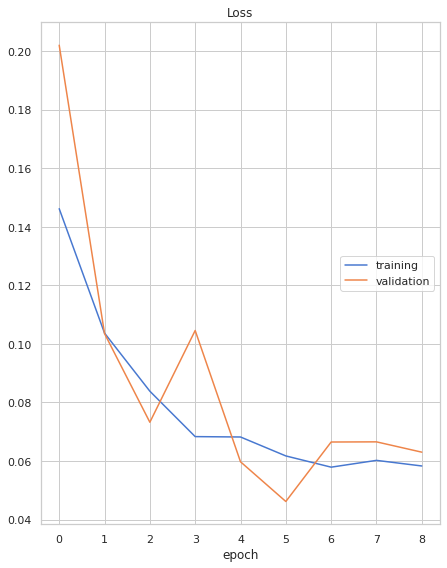

Loss
	training         	 (min:    0.058, max:    0.146, cur:    0.058)
	validation       	 (min:    0.046, max:    0.202, cur:    0.063)
184/184 - 4s - loss: 0.0583 - val_loss: 0.0630


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=callbacks, 
                    verbose=2,
                    validation_split=0.1, 
                    shuffle=False)

In [23]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

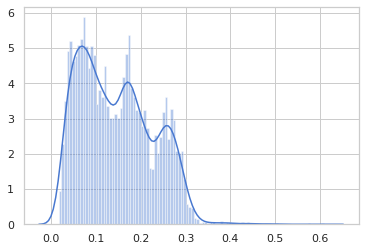

In [24]:
sns.distplot(train_mae_loss, bins=100, kde=True);

In [37]:
train_mae_loss.describe()

,Error
count,6523.000000
mean,0.145438
std,0.080599
min,0.016331
25%,0.075278
50%,0.136948
75%,0.204593
max,0.608345


In [25]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

## Detect Anomalies in the S&P 500 Index Data

We will detect anomalies by determining how well our model can reconstruct the input data.

1. Find MAE loss on training samples.
2. Find max or close to max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
3. If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [38]:
THRESHOLD = 0.608345

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [39]:
test_score_df

,date,close,loss,threshold,anomaly
6583,2012-02-08,1.216856,0.055838,0.608345,False
6584,2012-02-09,1.221625,0.057036,0.608345,False
6585,2012-02-10,1.199313,0.057741,0.608345,False
6586,2012-02-13,1.221194,0.058517,0.608345,False
6587,2012-02-14,1.218150,0.058511,0.608345,False
...,...,...,...,...,...
8187,2018-06-25,4.493228,0.955136,0.608345,True
8188,2018-06-26,4.507583,0.989352,0.608345,True
8189,2018-06-27,4.451431,0.999373,0.608345,True
8190,2018-06-28,4.491406,1.023639,0.608345,True


In [40]:
# plotting interactively
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

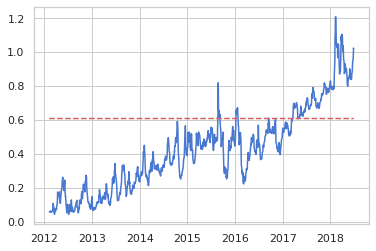

In [52]:
plt.plot(test[time_steps:].date, 
         test_score_df.loss)
plt.plot(test[time_steps:].date,
         test_score_df.threshold,
         'r--')
plt.show()

In [41]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7473,2015-08-24,2.518791,0.639436,0.608345,True
7474,2015-08-25,2.457439,0.751293,0.608345,True
7475,2015-08-26,2.632149,0.818954,0.608345,True
7476,2015-08-27,2.745147,0.763499,0.608345,True
7477,2015-08-28,2.748047,0.675890,0.608345,True


In [44]:
# plotting interactively 
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:]['close']),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies['close']),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()

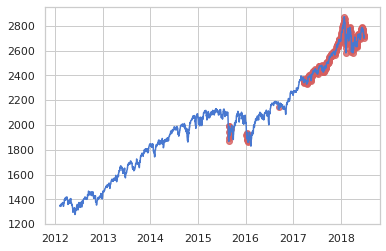

In [65]:
plt.plot(test[time_steps:].date, 
         scaler.inverse_transform(test[time_steps:]['close']))
plt.scatter(anomalies.date,
         scaler.inverse_transform(anomalies['close']),
         color='r',
         alpha=0.8)
plt.show()